In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import category_encoders
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

%matplotlib inline

In [2]:
def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")
X_train = X_train.drop(X_train.index[11172]) #dropped the last line, in order to both X and y dataframes to have the same number of rows

In [4]:
X_train.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,other_factor_2,other_factor_3,age_in_years
0,m,driving,front_left,NaN,NaN,NaN,NaN,50
1,m,on_bike,not_in_vehicle,in_unmarked_intersection,pedestrial_in_middle_of_street,NaN,NaN,42
2,f,driving,front_left,NaN,NaN,NaN,NaN,42
3,f,passenger,front_right,NaN,NaN,NaN,NaN,52
4,m,driving,front_left,NaN,NaN,NaN,NaN,45


In [5]:
y_train.head()

,0
0,1
1,1
2,1
3,0
4,1


In [6]:
X_train.shape

(11172, 8)

In [7]:
y_train.shape

(11172, 1)

In [8]:
X_train = X_train.drop(columns=["other_factor_3", "other_factor_2"])

In [9]:
X_train.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,age_in_years
0,m,driving,front_left,NaN,NaN,50
1,m,on_bike,not_in_vehicle,in_unmarked_intersection,pedestrial_in_middle_of_street,42
2,f,driving,front_left,NaN,NaN,42
3,f,passenger,front_right,NaN,NaN,52
4,m,driving,front_left,NaN,NaN,45


In [10]:
X_train = X_train.fillna({'other_factor_1': 'N/A or Unknown'})

In [11]:
X_train.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,age_in_years
0,m,driving,front_left,NaN,N/A or Unknown,50
1,m,on_bike,not_in_vehicle,in_unmarked_intersection,pedestrial_in_middle_of_street,42
2,f,driving,front_left,NaN,N/A or Unknown,42
3,f,passenger,front_right,NaN,N/A or Unknown,52
4,m,driving,front_left,NaN,N/A or Unknown,45


In [12]:
X_train = X_train.fillna({'other_person_location': 'unknown'})

In [13]:
X_train[['m_or_f']] = X_train[['m_or_f']].fillna(method='ffill')

In [14]:
X_train.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,age_in_years
0,m,driving,front_left,unknown,N/A or Unknown,50
1,m,on_bike,not_in_vehicle,in_unmarked_intersection,pedestrial_in_middle_of_street,42
2,f,driving,front_left,unknown,N/A or Unknown,42
3,f,passenger,front_right,unknown,N/A or Unknown,52
4,m,driving,front_left,unknown,N/A or Unknown,45


In [15]:
data_set = X_train.join(y_train)
data_set = data_set.rename(columns={'0': 'prediction'})

In [16]:
data_set.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,age_in_years,prediction
0,m,driving,front_left,unknown,N/A or Unknown,50,1
1,m,on_bike,not_in_vehicle,in_unmarked_intersection,pedestrial_in_middle_of_street,42,1
2,f,driving,front_left,unknown,N/A or Unknown,42,1
3,f,passenger,front_right,unknown,N/A or Unknown,52,0
4,m,driving,front_left,unknown,N/A or Unknown,45,1


In [17]:
data_set.prediction.value_counts()

1    7393
0    3779
Name: prediction, dtype: int64

In [18]:
pred_0 = len(data_set[data_set['prediction']==0])

In [19]:
pred_1_indices = data_set[data_set.prediction == 1].index

In [20]:
random_indices = np.random.choice(pred_1_indices, pred_0, replace=False)

In [21]:
len(random_indices)

3779

In [22]:
pred_0_indices = data_set[data_set.prediction == 0].index

In [23]:
under_sample_indices = np.concatenate([pred_0_indices, random_indices])

In [24]:
under_sample = data_set.loc[under_sample_indices]

In [25]:
under_sample.prediction.value_counts()

1    3779
0    3779
Name: prediction, dtype: int64

In [26]:
under_sample.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,age_in_years,prediction
3,f,passenger,front_right,unknown,N/A or Unknown,52,0
6,m,driving,front_left,unknown,N/A or Unknown,43,0
8,m,passenger,front_right,unknown,N/A or Unknown,55,0
10,m,driving,front_left,unknown,N/A or Unknown,45,0
16,m,driving,front_left,unknown,N/A or Unknown,50,0


In [28]:
under_sample.other_person_location.value_counts()

unknown                           6714
in_unmarked_intersection           340
middle_of_road_unknown             130
middle_of_road                     105
in_intersection_legal               60
roadside_not_intersection           51
in_intersection_possible_xwalk      44
on_roadway_intersection             42
not_intersection_not_road           22
in_intersection_no_xwalk            19
not_intersection_no_highway         10
not_highway_in_intersection          8
intersection_unknown                 6
not_known_not_intersection           4
xwalk_non_intersection               3
Name: other_person_location, dtype: int64

In [31]:
location_notunknown = len(under_sample[under_sample['other_person_location']!='unknown'])

In [33]:
unknown_ind = under_sample[under_sample.other_person_location == 'unknown'].index

In [34]:
random_unknown = np.random.choice(unknown_ind, location_notunknown, replace=False)

In [36]:
not_unk_ind = under_sample[under_sample.other_person_location != 'unknown'].index 

In [38]:
new_sample_ind = np.concatenate([random_unknown, not_unk_ind])

In [41]:
new_sample = under_sample.loc[new_sample_ind]

In [46]:
factor_notunknown = len(new_sample[new_sample['other_factor_1']!= 'N/A or Unknown'])

In [48]:
fac_unk_ind = new_sample[new_sample.other_factor_1 == 'N/A or Unknown'].index

In [49]:
random_fac_unk = np.random.choice(fac_unk_ind, factor_notunknown, replace=False)

In [50]:
notunk_ind = new_sample[new_sample.other_factor_1 != 'N/A or Unknown'].index

In [51]:
final_sample_ind = np.concatenate([random_fac_unk, notunk_ind])

In [52]:
final_sample = new_sample.loc[final_sample_ind]

In [53]:
final_sample.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,age_in_years,prediction
9635,m,driving,front_left,unknown,N/A or Unknown,40,0
8622,f,driving,front_left,unknown,N/A or Unknown,51,0
8472,m,on_bike,not_in_vehicle,intersection_unknown,N/A or Unknown,40,0
4803,m,driving,front_left,unknown,N/A or Unknown,45,1
9505,m,driving,front_left,unknown,N/A or Unknown,44,1


In [54]:
final_sample.shape

(1134, 7)

In [55]:
final_sample.prediction.value_counts()

0    582
1    552
Name: prediction, dtype: int64

In [63]:
encod = category_encoders.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)

In [64]:
sample_dummy = encod.fit_transform(final_sample)

In [67]:
sample_dummy.shape

(1134, 57)

In [130]:
sample_dummy.describe()

,m_or_f_m,m_or_f_f,person_attributes_driving,person_attributes_on_bike,person_attributes_on_foot,person_attributes_passenger,person_attributes_unknown_in_other_vehicle_type,person_attributes_in_stopped_vehicle,person_attributes_other_on_foot,seat_front_left,...,other_factor_1_unconscious_or_too_krunk,other_factor_1_traveling_on_closed_road,other_factor_1_swerved_out_of_lane,other_factor_1_uses_wheelchair,other_factor_1_physical_impairment,other_factor_1_failure_turn_lights_on,other_factor_1_was_doing_tide_challenge,other_factor_1_boarding_or_exiting_moving_vehicle,age_in_years,prediction
count,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,...,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000
mean,0.745150,0.254850,0.330688,0.071429,0.522928,0.059083,0.002646,0.007937,0.005291,0.330688,...,0.000882,0.002646,0.001764,0.001764,0.000882,0.000882,0.000882,0.000882,46.672840,0.486772
std,0.435969,0.435969,0.470668,0.257653,0.499694,0.235884,0.051389,0.088772,0.072579,0.470668,...,0.029696,0.051389,0.041978,0.041978,0.029696,0.029696,0.029696,0.029696,4.527022,0.500046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,1.000000


In [68]:
X_sample = sample_dummy.loc[:, sample_dummy.columns != 'prediction']
y_sample = sample_dummy.loc[:, sample_dummy.columns == 'prediction']

In [69]:
X_sample.shape

(1134, 56)

In [70]:
y_sample.shape

(1134, 1)

In [71]:
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size = 0.3, random_state=0)

In [72]:
X_sample_train.shape

(793, 56)

In [73]:
y_sample_train.shape

(793, 1)

In [74]:
first_model = LogisticRegression()

In [77]:
first_model.fit(X_sample_train, y_sample_train.prediction)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
first_pred = first_model.predict(X_sample_test)

In [79]:
first_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

In [80]:
recall_score(y_sample_test, first_pred)

0.28160919540229884

In [85]:
accuracy_score(y_sample_test, first_pred)

0.5131964809384164

In [96]:
second_model = DecisionTreeClassifier()

In [97]:
second_model.fit(X_sample_train, y_sample_train.prediction)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [98]:
second_pred = second_model.predict(X_sample_test)

In [99]:
recall_score(y_sample_test, second_pred)

0.39080459770114945

In [100]:
accuracy_score(y_sample_test, second_pred)

0.4838709677419355

In [204]:
third_model = RandomForestClassifier(max_features=49, max_depth=2)

In [205]:
third_model.fit(X_sample_train, y_sample_train.prediction)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=49, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [206]:
third_pred = third_model.predict(X_sample_test)

In [207]:
recall_score(y_sample_test, third_pred)

0.25862068965517243

In [208]:
accuracy_score(y_sample_test, third_pred)

0.5073313782991202

In [191]:
roc_auc_score(y_sample_test.prediction, third_pred)

0.5134730538922155

In [144]:
y_sample_test.head()

,prediction
9599,1
1235,1
6073,0
9556,0
10693,0


In [145]:
third_pred

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,

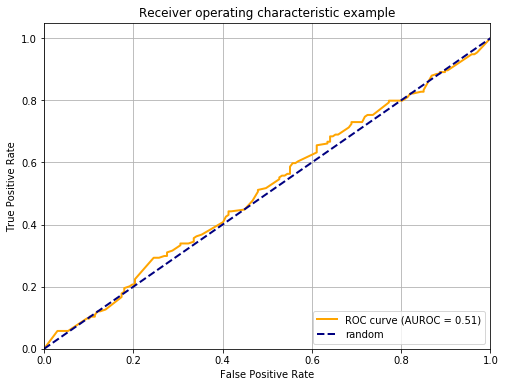

In [192]:
roc_auc = roc_auc_score(y_sample_test, third_pred)
fpr, tpr, thresholds = roc_curve(y_sample_test, third_pred)

plot_roc_curve(roc_auc, fpr, tpr)

In [194]:
estimator = RandomForestClassifier()
independent_variables = X_sample_train.columns
grid_search_parameter_space = {'max_depth': range(1, 10),
                   'max_features': range(1, len(independent_variables))
                  }

In [209]:
grid_search = GridSearchCV(
                estimator,
                grid_search_parameter_space,
                scoring="accuracy",
                return_train_score=True
)

In [210]:
grid_search.fit(X_sample_train, y_sample_train.prediction)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 10), 'max_features': range(1, 56)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [202]:
grid_search.best_params_

{'max_depth': 2, 'max_features': 49}